In [1]:
import pandas as pd
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from IPython.display import Image
from subprocess import call
import shap
from sklearn.metrics import accuracy_score
import joblib
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_tree, plot_importance
import xgboost as xgb
from xgboost import plot_tree, plot_importance
import geopandas as gpd

with open('./token.txt', 'r') as f:
    TOKEN = f.read()
    px.set_mapbox_access_token(TOKEN)

/home/stare/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def parse_time(value):
    hours = value // 100
    minutes = value % 100
    return pd.to_timedelta(f"{hours} hours {minutes} minutes")

def encodeCategorical(df):
    df_encoded = df.copy()
    df_encoded['daynight'] = df_encoded['daynight'].apply(lambda x: 1 if x != 'D' else 0)
    df_encoded['satellite'] = df_encoded['satellite'].apply(lambda x: 0 if x == 'N' else 1 if x == '1' else 2 if x == 'Terra' else 3)
    df_encoded['confidence'] = df_encoded['confidence'].apply(lambda x: 0 if x == 'l' else 1 if x == 'n' else 2 if x == 'h' else 3)
    return df_encoded

def featureEngineering(df):
    X = df.copy()
    X['acq_date'] = pd.to_datetime(X['acq_date'])
    X['month'] = X['acq_date'].dt.month
    X['day'] = X['acq_date'].dt.day
    X['weekday'] = X['acq_date'].dt.weekday
    X['hour'] = X['acq_time'].apply(parse_time).dt.components.hours
    return X

def encodeComuas(df):
    comunas = gpd.read_file('../django-api/app/data/comunas.geojson')

    """
        Comunas are ordered alphabetically by default. We want to order them by latitude like rows.
        This will help the model tree to make better decisions.
        And it will also help us to visualize the results in a more intuitive way.
        There is a total of 340 comunas in Chile, if the model decides to cut by > 150, 
        we intuitively know that it is somewhat in the middle of the country.
    """
    comunas['coords'] = comunas['geometry'].apply(lambda x: x.representative_point().coords[:][0][1])
    comunas.sort_values(by='coords', inplace=True, ascending=False)
    comunas.reset_index(drop=True, inplace=True)

    comunas_index = comunas['comuna']

    if 'comuna' not in df.columns:
        print("The DataFrame does not have a 'comuna' column.")
        return
    
    if df['comuna'].isnull().any():
        print("The 'comuna' column contains null values.")
        return

    comunas_map = {}

    for i, comuna in enumerate(comunas_index):
        comunas_map[comuna] = i
        comunas_map[i] = comuna

    def encodeComuna(comuna):
        return comunas_map[comuna]

    df['comuna'] = df['comuna'].apply(encodeComuna)

    return df, comunas_map

def decodeComuna(comuna, comunas_map):
    return comunas_map[comuna]

## Preprocessing

In [3]:
df = pd.read_parquet('../django-api/app/fires_merged_comunas.parquet')

In [4]:
comunas = gpd.read_file('../django-api/app/data/comunas.geojson')

In [5]:
df = df[df['comuna'].notnull()]

In [6]:
# Not null data, aka labeled data
labeled = df[df['type'].notnull()]

In [7]:
unlabeled = df[df['type'].isnull()]

In [8]:
unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212239 entries, 269088 to 580028
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   latitude    212239 non-null  float64       
 1   longitude   212239 non-null  float64       
 2   brightness  212239 non-null  float64       
 3   scan        212239 non-null  float64       
 4   track       212239 non-null  float64       
 5   acq_date    212239 non-null  datetime64[ns]
 6   acq_time    212239 non-null  int64         
 7   satellite   212239 non-null  object        
 8   instrument  212239 non-null  object        
 9   confidence  212239 non-null  object        
 10  version     212239 non-null  object        
 11  bright_t31  212239 non-null  float64       
 12  frp         212239 non-null  float64       
 13  daynight    212239 non-null  object        
 14  type        0 non-null       float64       
 15  comuna      212239 non-null  object        
dtypes:

In [9]:
train = labeled.copy()

df_encoded = encodeCategorical(train)
df_encoded, comunas_map = encodeComuas(df_encoded)

In [10]:
df_encoded.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,comuna
0,-23.820446,-70.320282,301.51,0.74,0.76,2013-01-01,448,0,VIIRS,1,1,285.54,2.38,1,2.0,17
1,-23.823833,-70.318871,306.90,0.74,0.76,2013-01-01,448,0,VIIRS,1,1,285.80,2.33,1,2.0,17
2,-26.430983,-69.475632,299.73,0.58,0.70,2013-01-01,448,0,VIIRS,1,1,279.61,2.86,1,2.0,19
3,-32.760929,-71.476440,309.70,0.52,0.67,2013-01-01,448,0,VIIRS,1,1,285.42,2.50,1,3.0,54
4,-34.624073,-71.000023,319.97,0.44,0.63,2013-01-01,448,0,VIIRS,1,1,290.28,2.27,1,0.0,162


In [11]:
unlabeled_encoded = encodeCategorical(unlabeled)
unlabeled_encoded, comunas_map = encodeComuas(unlabeled_encoded)

In [12]:
unlabeled_encoded.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,comuna
269088,-23.36115,-67.72974,312.8,0.38,0.36,2019-12-04,536,1,VIIRS,1,2.0NRT,269.7,1.5,1,NaN,15
269089,-23.82504,-70.31619,328.4,0.43,0.38,2019-12-04,536,1,VIIRS,1,2.0NRT,287.1,1.8,1,NaN,17
269090,-23.82432,-70.32031,297.7,0.43,0.38,2019-12-04,536,1,VIIRS,1,2.0NRT,285.5,1.8,1,NaN,17
269091,-22.31535,-68.88089,328.7,0.40,0.37,2019-12-04,536,1,VIIRS,1,2.0NRT,284.9,4.0,1,NaN,13
269092,-23.36057,-67.73347,317.6,0.38,0.36,2019-12-04,536,1,VIIRS,1,2.0NRT,270.4,1.5,1,NaN,15


## Feature Engineering

In [13]:
df_encoded.shape, unlabeled_encoded.shape

((367362, 16), (212239, 16))

In [14]:
X = df_encoded.drop(columns=['type'])
y = df_encoded['type']

# convert the type = 2, 3 to 1
y = y.apply(lambda x: 1 if x > 1 else x)

In [15]:
X.columns

Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_t31', 'frp', 'daynight', 'comuna'],
      dtype='object')

In [16]:
X = featureEngineering(X)

In [45]:
features = ['brightness', 'bright_t31', 'frp']

## Training

In [46]:
Xn = X[features]

In [47]:
Xn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367362 entries, 0 to 465149
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   brightness  367362 non-null  float64
 1   bright_t31  367362 non-null  float64
 2   frp         367362 non-null  float64
dtypes: float64(3)
memory usage: 11.2 MB


In [48]:
X_train, X_temp, y_train, y_temp = train_test_split(Xn, y, test_size=0.3, random_state=69)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=69)

In [49]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'lambda': 0.5,
    'colsample_bytree': 0.8,
    'seed': 69
}

num_rounds = 1000
watchlist = [(dtrain, 'train'), (dval, 'eval')]

model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=10)

y_pred = model.predict(dtest)

y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy on the test set: {accuracy:.4f}")

[0]	train-logloss:0.65193	eval-logloss:0.65206
[1]	train-logloss:0.61940	eval-logloss:0.61961
[2]	train-logloss:0.59225	eval-logloss:0.59253
[3]	train-logloss:0.56971	eval-logloss:0.57005
[4]	train-logloss:0.55025	eval-logloss:0.55064
[5]	train-logloss:0.53384	eval-logloss:0.53423
[6]	train-logloss:0.51973	eval-logloss:0.52015
[7]	train-logloss:0.50591	eval-logloss:0.50639
[8]	train-logloss:0.49401	eval-logloss:0.49454


[9]	train-logloss:0.48505	eval-logloss:0.48557
[10]	train-logloss:0.47703	eval-logloss:0.47759
[11]	train-logloss:0.47015	eval-logloss:0.47076
[12]	train-logloss:0.46415	eval-logloss:0.46477
[13]	train-logloss:0.45742	eval-logloss:0.45811
[14]	train-logloss:0.45168	eval-logloss:0.45247
[15]	train-logloss:0.44774	eval-logloss:0.44854
[16]	train-logloss:0.44323	eval-logloss:0.44413
[17]	train-logloss:0.43934	eval-logloss:0.44031
[18]	train-logloss:0.43670	eval-logloss:0.43769
[19]	train-logloss:0.43362	eval-logloss:0.43469
[20]	train-logloss:0.43158	eval-logloss:0.43263
[21]	train-logloss:0.42909	eval-logloss:0.43022
[22]	train-logloss:0.42694	eval-logloss:0.42819
[23]	train-logloss:0.42510	eval-logloss:0.42643
[24]	train-logloss:0.42380	eval-logloss:0.42512
[25]	train-logloss:0.42265	eval-logloss:0.42401
[26]	train-logloss:0.42169	eval-logloss:0.42305
[27]	train-logloss:0.42034	eval-logloss:0.42177
[28]	train-logloss:0.41924	eval-logloss:0.42072
[29]	train-logloss:0.41854	eval-logloss:0

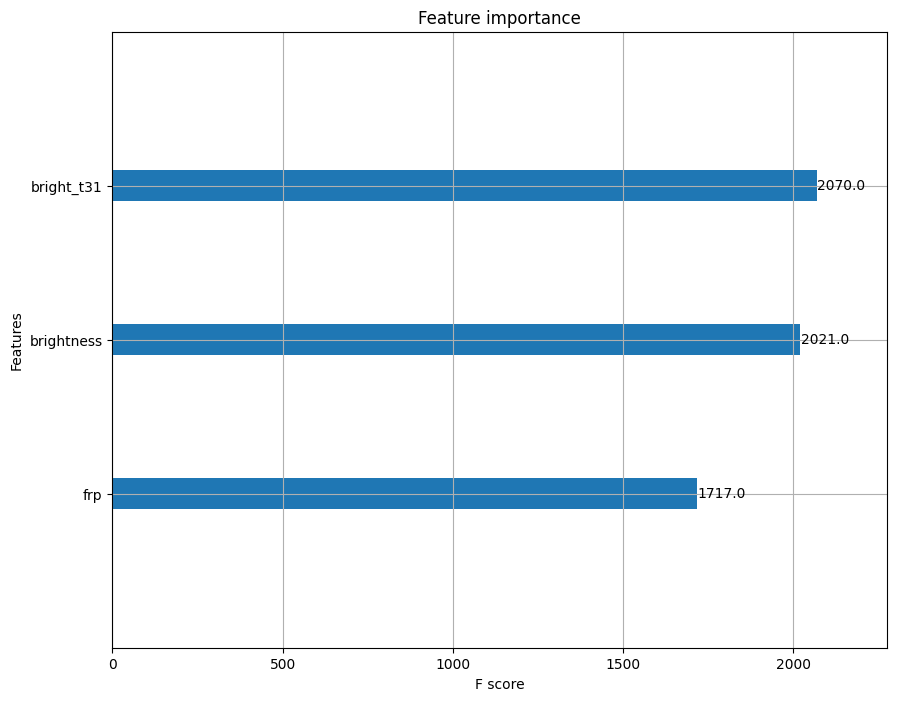

In [50]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, ax=ax)
plt.show()

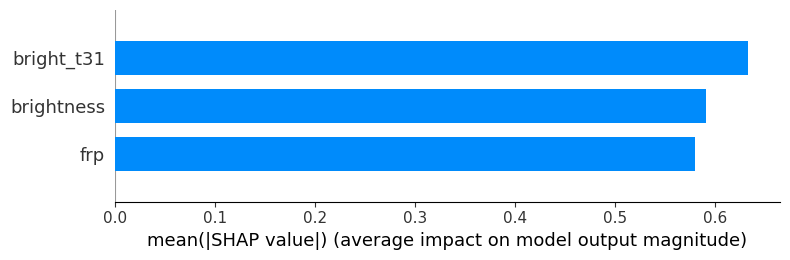

In [51]:
# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xn)

shap.summary_plot(shap_values, Xn, plot_type="bar")


<AxesSubplot: >

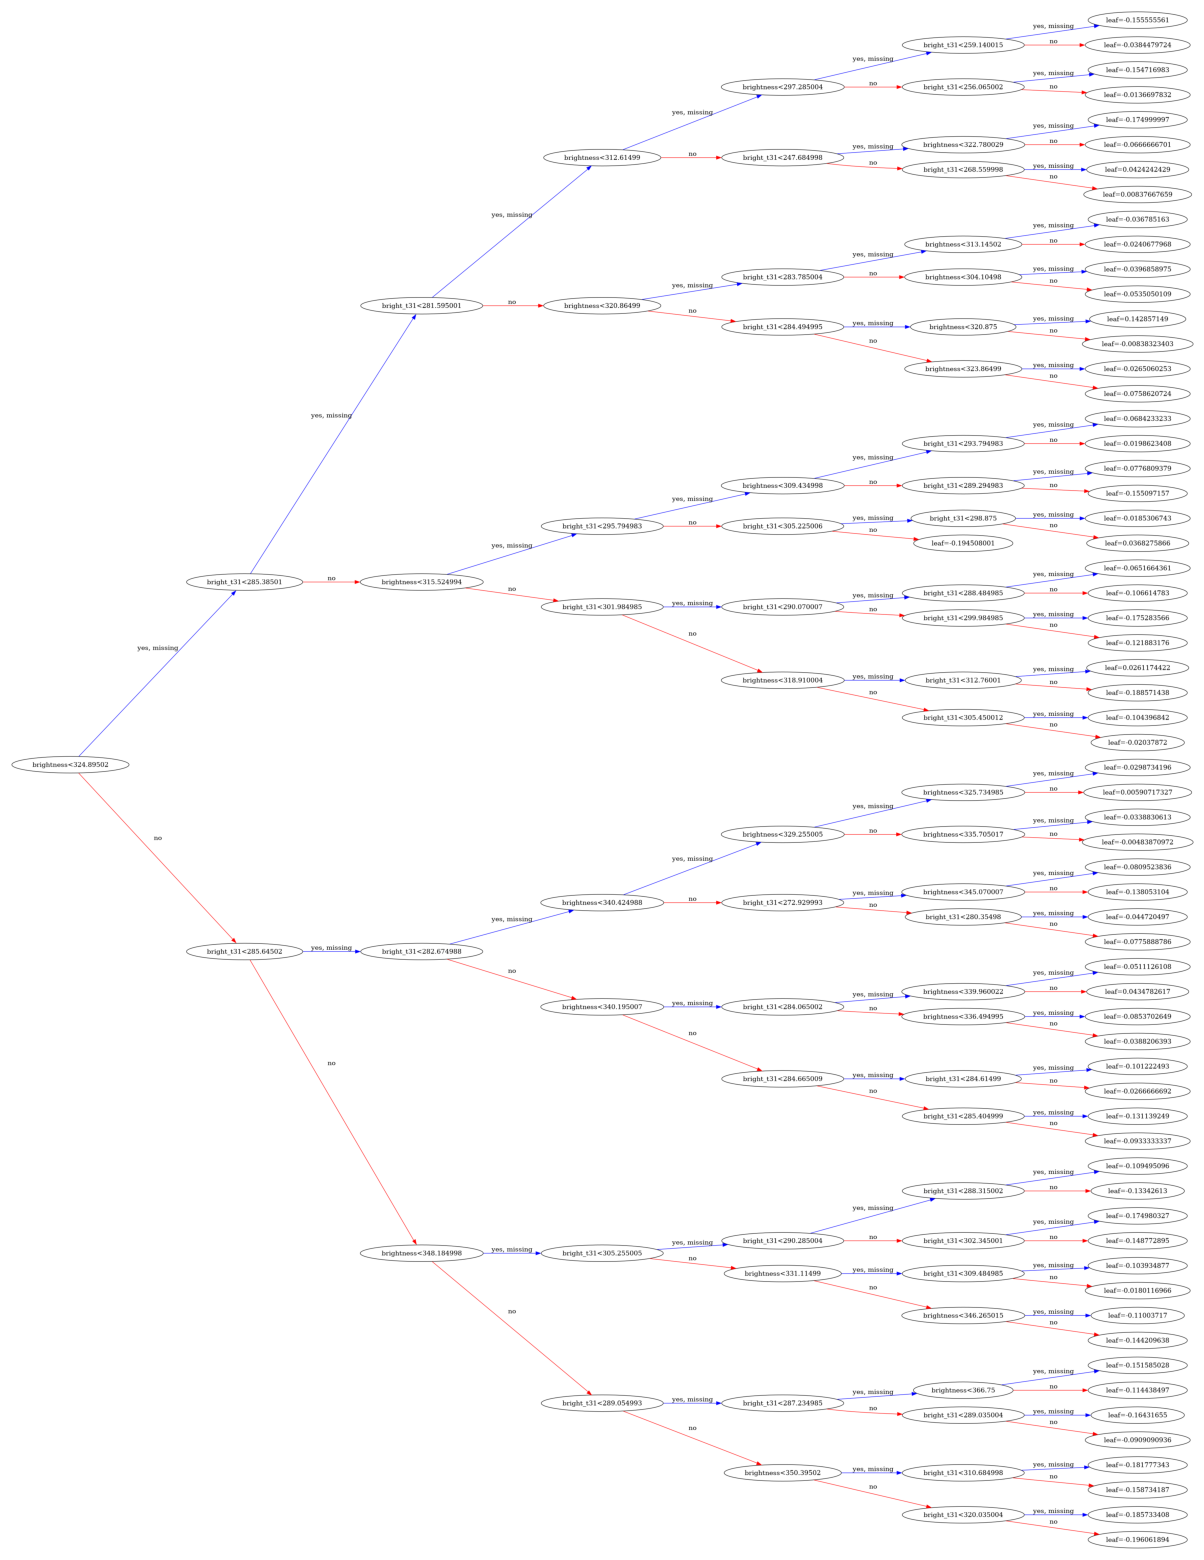

In [52]:
# Plot xgboost tree
fig, ax = plt.subplots(figsize=(20, 20))
plot_tree(model, rankdir='LR', num_trees=0, ax=ax)

In [53]:
cv_results = xgb.cv(params, dtrain, num_rounds, nfold=5, metrics='auc', seed=123)

In [54]:
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.776319,0.000710,0.773768,0.000594
1,0.782304,0.004707,0.779411,0.004273
2,0.790140,0.007456,0.787189,0.006567
3,0.793549,0.006364,0.790700,0.005897
4,0.795020,0.006563,0.792019,0.005619
...,...,...,...,...
995,0.862941,0.000205,0.809706,0.001065
996,0.862991,0.000202,0.809702,0.001082
997,0.863031,0.000210,0.809696,0.001076
998,0.863073,0.000217,0.809696,0.001080


In [55]:
test_points = [
  {
    "id": 589898,
    "latitude": -33.17845,
    "longitude": -71.47662,
    "brightness": 313.81,
    "scan": 3.8,
    "track": 1.82,
    "acq_date": "2024-02-08",
    "acq_time": 1505,
    "satellite": "Terra",
    "instrument": "MODIS",
    "confidence": "n",
    "version": "6.1NRT",
    "bright_t31": 300.64,
    "frp": 50.71,
    "daynight": "D",
    "ftype": 0,
    "comuna": "CASABLANCA"
  },
  {
    "id": 589882,
    "latitude": -34.78876,
    "longitude": -71.01136,
    "brightness": 322.39,
    "scan": 0.5,
    "track": 0.41,
    "acq_date": "2024-02-08",
    "acq_time": 603,
    "satellite": "N",
    "instrument": "VIIRS",
    "confidence": "n",
    "version": "2.0NRT",
    "bright_t31": 290.19,
    "frp": 2.48,
    "daynight": "N",
    "ftype": 0,
    "comuna": "CHIMBARONGO"
  },
  {
    "id": 589881,
    "latitude": -36.7347,
    "longitude": -72.10268,
    "brightness": 298.39,
    "scan": 0.47,
    "track": 0.4,
    "acq_date": "2024-02-08",
    "acq_time": 603,
    "satellite": "N",
    "instrument": "VIIRS",
    "confidence": "n",
    "version": "2.0NRT",
    "bright_t31": 287.17,
    "frp": 0.61,
    "daynight": "N",
    "ftype": 0,
    "comuna": "CHILLAN"
  },
  {
    "id": 589876,
    "latitude": -33.68943,
    "longitude": -70.73763,
    "brightness": 301.29,
    "scan": 0.5,
    "track": 0.41,
    "acq_date": "2024-02-08",
    "acq_time": 601,
    "satellite": "N",
    "instrument": "VIIRS",
    "confidence": "n",
    "version": "2.0NRT",
    "bright_t31": 290.05,
    "frp": 0.75,
    "daynight": "N",
    "ftype": 0,
    "comuna": "BUIN"
  },
  {
    "id": 589894,
    "latitude": -37.19729,
    "longitude": -73.21754,
    "brightness": 296.63,
    "scan": 0.56,
    "track": 0.52,
    "acq_date": "2024-02-08",
    "acq_time": 514,
    "satellite": "1",
    "instrument": "VIIRS",
    "confidence": "n",
    "version": "2.0NRT",
    "bright_t31": 286.57,
    "frp": 1.92,
    "daynight": "N",
    "ftype": 0,
    "comuna": "ARAUCO"
  },
  {
    "id": 589895,
    "latitude": -36.85017,
    "longitude": -72.43471,
    "brightness": 303.59,
    "scan": 0.52,
    "track": 0.5,
    "acq_date": "2024-02-08",
    "acq_time": 514,
    "satellite": "1",
    "instrument": "VIIRS",
    "confidence": "n",
    "version": "2.0NRT",
    "bright_t31": 286.06,
    "frp": 1.15,
    "daynight": "N",
    "ftype": 0,
    "comuna": "QUILLON"
  },
  {
    "id": 589896,
    "latitude": -36.84878,
    "longitude": -72.44054,
    "brightness": 300.28,
    "scan": 0.52,
    "track": 0.5,
    "acq_date": "2024-02-08",
    "acq_time": 514,
    "satellite": "1",
    "instrument": "VIIRS",
    "confidence": "n",
    "version": "2.0NRT",
    "bright_t31": 284.96,
    "frp": 1.15,
    "daynight": "N",
    "ftype": 0,
    "comuna": "QUILLON"
  },
  {
    "id": 589887,
    "latitude": -34.78888,
    "longitude": -71.01315,
    "brightness": 325.29,
    "scan": 0.49,
    "track": 0.48,
    "acq_date": "2024-02-08",
    "acq_time": 512,
    "satellite": "1",
    "instrument": "VIIRS",
    "confidence": "n",
    "version": "2.0NRT",
    "bright_t31": 290.37,
    "frp": 3.16,
    "daynight": "N",
    "ftype": 0,
    "comuna": "CHIMBARONGO"
  },
  {
    "id": 589893,
    "latitude": -33.29171,
    "longitude": -70.72781,
    "brightness": 311.99,
    "scan": 0.51,
    "track": 0.49,
    "acq_date": "2024-02-08",
    "acq_time": 512,
    "satellite": "1",
    "instrument": "VIIRS",
    "confidence": "n",
    "version": "2.0NRT",
    "bright_t31": 293.12,
    "frp": 1.67,
    "daynight": "N",
    "ftype": 0,
    "comuna": "COLINA"
  },
  {
    "id": 589888,
    "latitude": -34.7845,
    "longitude": -71.01165,
    "brightness": 304.21,
    "scan": 0.49,
    "track": 0.48,
    "acq_date": "2024-02-08",
    "acq_time": 512,
    "satellite": "1",
    "instrument": "VIIRS",
    "confidence": "n",
    "version": "2.0NRT",
    "bright_t31": 289.1,
    "frp": 0.7,
    "daynight": "N",
    "ftype": 0,
    "comuna": "CHIMBARONGO"
  }
]

In [56]:
test_points_fake = [
      {
    "id": 589888,
    "latitude": -34.7845,
    "longitude": -71.01165,
    "brightness": 304.21,
    "scan": 0,
    "track": 0,
    "acq_date": "2024-02-08",
    "acq_time": 512,
    "satellite": "1",
    "instrument": "VIIRS",
    "confidence": "n",
    "version": "2.0NRT",
    "bright_t31": 289.1,
    "frp": 0,
    "daynight": "N",
    "ftype": 0,
    "comuna": "AISEN"
  }
]

In [57]:
new_data = pd.DataFrame(test_points)
new_data_encoded = featureEngineering(new_data)
new_data_encoded = encodeCategorical(new_data_encoded)
new_data_encoded, comunas_map = encodeComuas(new_data_encoded)

new_data_encoded = new_data_encoded[features]

new_data_dmatrix = xgb.DMatrix(new_data_encoded)
new_data_pred = model.predict(new_data_dmatrix)

print(new_data_pred)
new_data_pred = [1 if pred > 0.5 else 0 for pred in new_data_pred]
print(new_data_pred)

[0.13649186 0.16599098 0.30232254 0.23331735 0.45398688 0.3890335
 0.43512958 0.11663764 0.05419142 0.21036004]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [58]:
# Export model
model.save_model('./models/xgboost_comunas.model')